In [40]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, accuracy_score, recall_score, make_scorer, plot_confusion_matrix

#sys.path.append('C:\\Users\\William\\Desktop\\Builds')
##https://github.com/willarliss/MC-Generate
from mc_generate import MCGen

---
# Training

Build a class to hold the model. Load in corpus and set aside a holdout set on initialization. Include methods for upsampling, training, predicting, and evaluating

In [41]:
class TextClassifier:
    
    def __init__(self, fname):
        
        corpus = pd.read_csv(fname)
        
        self.X, self.X_test, self.y, self.y_test = train_test_split(
            corpus['text'], 
            corpus['class'],
            random_state=42,
            stratify=corpus['class'],
            )
        
    def oversample(self, minor, n):
    
        corpus = pd.DataFrame(zip(self.X, self.y), columns=['text', 'class'])
        samples = corpus[corpus['class']==minor]['text'].values
        upsampling = pd.DataFrame([], columns=['text', 'class'])

        mcg = MCGen(order=3, minimum=5, reduce=True)
        mcg.build(samples)
        upsampling['text'] = mcg.generate(n)
        upsampling['class'] = [minor]*n

        corpus = corpus.append(upsampling)
        self.X = corpus['text']
        self.y = corpus['class']
        
        return self
    
    def train(self, classifier, X_train=None, y_train=None, fit=True):
        
        self.clf = Pipeline([
            #('cv', CountVectorizer(max_features=10000, ngram_range=(1,1), stop_words='english')), # LinearSVC imbalanced
            ('cv', CountVectorizer(max_features=None, ngram_range=(1,2), stop_words=None)), # LinearSVC balanced
            #('cv', CountVectorizer(max_features=10000, ngram_range=(1,3), stop_words='english')), # Multinomial NB
            ('tfidf', TfidfTransformer()),
            #('tfidf', TfidfTransformer(smooth_idf=True)), # MultinomialNB balanced
            ('clf', classifier),
            ])
        
        if fit:
            self.clf.fit(X_train, y_train)
        
        return self.clf       
    
    def predict(self, X_test):
        
        self.preds = self.clf.predict(X_test)
        
        return self.preds
    
    def evaluate(self, y_test):
        
        self.score = {
            'accuracy': accuracy_score(y_test, self.preds),
            'f1_macro': f1_score(y_test, self.preds, average='macro'),
            'recall_macro': recall_score(y_test, self.preds, average='macro'),
            }
        
        return self.score

Build a function for cross validation to evaluate the performance of different models

In [42]:
def cross_validation(brain, name, splits=7): 
    
    cv = StratifiedKFold(n_splits=splits, shuffle=True)
    X, y = np.array(brain.X), np.array(brain.y)
    
    classifiers = { 
        'NB': MultinomialNB(fit_prior=False, alpha=0.1),
        'SVC': LinearSVC(dual=True, C=1.0, loss='squared_hinge', penalty='l2'),
        }
          
    for train_index, test_index in cv.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        brain.train(classifiers[name], X_train, y_train)
        brain.predict(X_test)
        
        print(brain.evaluate(y_test))

Build a function for grid search optimization

In [43]:
def grid_search(brain, name): 
        
    classifiers = { 
        'NB': MultinomialNB(),
        'SVC': LinearSVC(),
        }
    
    parameters = {
        'NB':{
            'clf__alpha': (0.1, 1, 10),
            'clf__fit_prior': (True, False),
            'cv__stop_words': ('english', None),
            'cv__ngram_range': ((1,1), (1,2), (1,3)),
            'cv__max_features': (None, 10_000),
            'tfidf__norm': ('l1', 'l2'),
            'tfidf__smooth_idf': (True, False),
            },
        'SVC':{
            'clf__C': (0.1, 1, 10),
            'clf__dual': (True, False),
            'clf__penalty': ('l1', 'l2'),
            'clf__loss': ('hinge', 'squared_hinge'),
            'cv__stop_words': ('english', None),
            'cv__ngram_range': ((1,1), (1,2), (1,3)),
            'cv__max_features': (None, 10_000),
            'tfidf__norm': ('l1', 'l2'),
            'tfidf__smooth_idf': (True, False),
            },       
        }
                          
    brain.train(classifiers[name], fit=False)
    gs_reg = GridSearchCV(brain.clf, parameters[name], cv=3, scoring=['accuracy', 'f1_macro', 'recall_macro'], refit='f1_macro')
    gs_reg.fit(np.array(brain.X), np.array(brain.y))

    print(name, gs_reg.best_score_, gs_reg.best_params_) 

---
### Imbalanced

Optimize both models on an imbalanced corpus. First read in the data and note the stratification

In [44]:
model = TextClassifier('../data/corpus.csv')
model.y.value_counts(normalize=True)

1    0.480413
0    0.444124
2    0.075463
Name: class, dtype: float64

Perform grid search optimization

In [46]:
grid_search(model, 'NB')

In [47]:
grid_search(model, 'SVC')

Evaluate with cross validation

In [48]:
cross_validation(model, 'NB')

In [49]:
cross_validation(model, 'SVC')

---
### Balanced - Oversampled

Optimize both models on a balanced corpus. First read in the data, perform synthetic oversampling, and note the new stratification

In [50]:
model = TextClassifier('../data/corpus.csv')
model.oversample(minor=2, n=3000)
model.y.value_counts(normalize=True)

1    0.353118
0    0.326444
2    0.320438
Name: class, dtype: float64

Perform grid search optimization

In [51]:
grid_search(model, 'NB')

In [52]:
grid_search(model, 'SVC')

Evaluate with cross validation

In [53]:
cross_validation(model, 'NB')

In [54]:
cross_validation(model, 'SVC')

---
# Testing

Build a new class to hold the deployment model. Load in corpus and set aside a holdout set on initialization. Include methods for upsampling, training, predicting, and evaluating

In [55]:
class TextClassifier:
    
    def __init__(self, fname):
        
        corpus = pd.read_csv(fname)
        
        self.X, self.X_test, self.y, self.y_test = train_test_split(
            corpus['text'], 
            corpus['class'],
            random_state=42,
            stratify=corpus['class'],
            )
        
    def oversample(self, minor, n):
    
        corpus = pd.DataFrame(zip(self.X, self.y), columns=['text', 'class'])
        samples = corpus[corpus['class']==minor]['text'].values
        upsampling = pd.DataFrame([], columns=['text', 'class'])

        mcg = MCGen(order=3, minimum=5, reduce=True)
        mcg.build(samples)
        upsampling['text'] = mcg.generate(n)
        upsampling['class'] = [minor]*n

        corpus = corpus.append(upsampling)
        self.X = corpus['text']
        self.y = corpus['class']
        
        return self
    
    def train(self, X_train=None, y_train=None, fit=True):
        
        self.clf = Pipeline([
            ('cv', CountVectorizer(max_features=10000, ngram_range=(1,3), stop_words='english')),
            ('tfidf', TfidfTransformer(smooth_idf=True)),
            ('nb', MultinomialNB(fit_prior=False, alpha=0.1)),
            ])
        
        if fit:
            self.clf.fit(X_train, y_train)
        
        return self.clf       
    
    def predict(self, X_test):
        
        self.preds = self.clf.predict(X_test)
        
        return self.preds
    
    def evaluate(self, y_test):
        
        self.score = {
            'accuracy': accuracy_score(y_test, self.preds),
            'f1_macro': f1_score(y_test, self.preds, average='macro'),
            'recall_macro': recall_score(y_test, self.preds, average='macro'),
            }
        
        return self.score

Initialize the model and upsample the minority class (Lewis). Then, check the models training performance

In [11]:
model = TextClassifier('../data/corpus.csv')
model.oversample(minor=2, n=3000)

model.train(model.X, model.y)
model.predict(model.X)
model.evaluate(model.y)

{'accuracy': 0.9843667196608373,
 'f1_macro': 0.9842284943246743,
 'recall_macro': 0.9842554615732274}

Evaluate the model's performance on unseen documents

In [10]:
model.predict(model.X_test)
model.evaluate(model.y_test)

{'accuracy': 0.9610670511896179,
 'f1_macro': 0.928275423718549,
 'recall_macro': 0.9352481845391084}

---
# Analysis

In [4]:
mapping = {2: 'Lewis', 1: 'Martin', 0: 'Tolkien'}
mapping

{2: 'Lewis', 1: 'Martin', 0: 'Tolkien'}

Plot a confusion matrix on the unseen documents

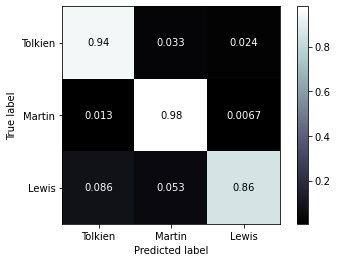

In [12]:
model = TextClassifier('../data/corpus.csv')
model.oversample(minor=2, n=3000)

plot_confusion_matrix(
    model.train(model.X, model.y),
    model.X_test,
    model.y_test,
    normalize='true',
    display_labels=['Tolkien', 'Martin', 'Lewis'],
    cmap=plt.cm.bone,    
    )

---

Create sparse matrix from corpus

In [35]:
model = TextClassifier('../data/corpus.csv')

cv = CountVectorizer(
    max_features=10000, 
    ngram_range=(1,3), 
    stop_words='english',
    )

df = pd.DataFrame(zip(model.y, model.X), columns=['class', 'text'])

bag = cv.fit_transform(df['text'])
bag = pd.DataFrame(bag.toarray(), columns=[cv.get_feature_names()])

df = pd.merge(df, bag, left_index=True, right_index=True)

---

Identify how many unique words each class has then list the top 5 most frequent unique words for each class

In [36]:
words = df[df['class']==2][bag.columns].sum().sort_values()
lewis_words = set(i[0] for i in list(words[words>0].index))

words = df[df['class']==1][bag.columns].sum().sort_values()
martin_words = set(i[0] for i in list(words[words>0].index))

words = df[df['class']==0][bag.columns].sum().sort_values()
tolkien_words = set(i[0] for i in list(words[words>0].index))

lewis_words_unique = lewis_words.difference(martin_words, tolkien_words)
martin_words_unique = martin_words.difference(lewis_words, tolkien_words)
tolkien_words_unique = tolkien_words.difference(martin_words, lewis_words)

print(len(lewis_words_unique), len(martin_words_unique), len(tolkien_words_unique))

print()

columns = [col for col in list(bag.columns) if col[0] in lewis_words_unique]
print(df[df['class']==2][columns].sum().sort_values().tail(5))

print()

columns = [col for col in list(bag.columns) if col[0] in martin_words_unique]
print(df[df['class']==1][columns].sum().sort_values().tail(5))

print()

columns = [col for col in list(bag.columns) if col[0] in tolkien_words_unique]
print(df[df['class']==0][columns].sum().sort_values().tail(5))

37 2072 640

(prince caspian,)      34
(magicians nephew,)    39
(silver chair,)        45
(caspian,)             51
(susan,)               63
dtype: int64

(sansa,)      763
(tyrion,)     773
(bran,)       865
(dany,)      1051
(jon,)       2000
dtype: int64

(balrog,)       132
(eru,)          153
(arda,)         157
(galadriel,)    190
(morgoth,)      273
dtype: int64


---

Find the intersection of words in each class

In [37]:
words = df[df['class']==2][bag.columns].sum().sort_values()
lewis_words = set(i[0] for i in list(words[words>0].index))

words = df[df['class']==1][bag.columns].sum().sort_values()
martin_words = set(i[0] for i in list(words[words>0].index))

words = df[df['class']==0][bag.columns].sum().sort_values()
tolkien_words = set(i[0] for i in list(words[words>0].index))

lewis_martin = (lewis_words&martin_words).difference(tolkien_words)
lewis_tolkien = (lewis_words&tolkien_words).difference(martin_words)
martin_tolkien = (martin_words&tolkien_words).difference(lewis_words)

print(len(lewis_martin), len(lewis_tolkien), len(martin_tolkien))

print()

columns = [col for col in list(bag.columns) if col[0] in lewis_martin]
print('lewis and martin, not tolkien')
print(df[(df['class']==2) | (df['class']==1)][columns].sum().sort_values().tail(5))

print()

columns = [col for col in list(bag.columns) if col[0] in lewis_tolkien]
print('lewis and tolkien, not martin')
print(df[(df['class']==2) | (df['class']==0)][columns].sum().sort_values().tail(5))

print()

columns = [col for col in list(bag.columns) if col[0] in martin_tolkien]
print('martin and tolkien, not tolkien')
print(df[(df['class']==1) | (df['class']==0)][columns].sum().sort_values().tail(5))

91 55 4309

lewis and martin, not tolkien
(castles,)           32
(entire series,)     34
(trap,)              37
(islands,)           91
(castle,)           147
dtype: int64

lewis and tolkien, not martin
(aslan,)      68
(lewis,)      74
(smaug,)     113
(mordor,)    158
(narnia,)    374
dtype: int64

martin and tolkien, not tolkien
(tolkiens,)        513
(middle earth,)    576
(elves,)           590
(stark,)           678
(grrm,)            752
dtype: int64
